In [1]:
import gzip
import pickle
import glob
import pandas as pd
import numpy as np
import os
from metient.util import eval_util as eutil
from metient.util.globals import *
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import itertools

REPO_DIR = os.path.join(os.getcwd(), "../../")

METRICS = ["Migration", "Comigration", "Seeding site"]
DATASET_NAMES = [ "HGSOC", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_orchard", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/tracerx_trees_multirun_07052024/calibrate",)]

num_bootstrap_samples = 100

num_mets = []
dataset_to_pickle_files = {dataset:[] for dataset in DATASET_NAMES}
for dataset_name, calibrate_dir in zip(DATASET_NAMES, CALIBRATE_DIRS):
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    print(calibrate_dir)
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            num_sites = len(pkl[OUT_SITES_KEY])
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            #if num_sites > 2:
            dataset_to_pickle_files[dataset_name].append((fn, num_sites))
            num_mets.append(num_sites)

def convert_thetas_to_alt_metrics(thetas):
    wtot = thetas[0] + thetas[1]
    delta = thetas[1]/wtot
    return wtot, delta, thetas[2]
    
sizes = {k:len(v) for k,v in dataset_to_pickle_files.items()}
sizes


/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/mcpherson_ovarian_2016/metient_outputs/solve_polys/calibrate
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_orchard/calibrate
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/gundem_neuroblastoma_2023/metient_outputs/solve_polys/calibrate
/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/calibrate_analysis/../../data/tracerx_nsclc/metient_outputs/tracerx_trees_multirun_07052024/calibrate


{'HGSOC': 13, 'Melanoma': 7, 'HR-NB': 30, 'NSCLC': 128}

### How consistent are the thetas when calibrated on random samples within the same cancer type cohort?

In [6]:
data = []


# Bootstrap sampling
for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    for dataset in dataset_to_pickle_files:
        matching_files = [x[0] for x in dataset_to_pickle_files[dataset]]
        print(len(matching_files))
        if len(matching_files) == 0:
            continue
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
        thetas = eutil.get_max_cross_ent_thetas(pickle_file_list=bootstrap_sample)
        #thetas = convert_thetas_to_alt_metrics(thetas)
        for midx, metric in enumerate(METRICS):
            data.append([dataset, metric, thetas[midx]])

thetas_split_on_same_cohort = pd.DataFrame(data, columns=["dataset", "Parsimony metric", "Fit theta"])
thetas_split_on_same_cohort.to_csv('thetas_split_on_same_cohort.csv') 
thetas_split_on_same_cohort


**** RUN 1 ***
13
Calibrating to 3 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3344, 0.3328, 0.3328], grad_fn=<DivBackward0>)
7
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 9 patients
Optimized thetas: tensor([0.6059, 0.1682, 0.2259], grad_fn=<DivBackward0>)
128
Calibrating to 21 patients
Optimized thetas: tensor([0.4473, 0.3314, 0.2213], grad_fn=<DivBackward0>)

**** RUN 2 ***
13
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3344, 0.3328, 0.3328], grad_fn=<DivBackward0>)
7
30
Calibrating to 8 patients
Optimized thetas: tensor([0.7608, 0.1147, 0.1245], grad_fn=<DivBackward0>)
128
Calibrating to 23 patients
Optimized thetas: tensor([0.5890, 0.2593, 0.1517], grad_fn=<DivBackward0>)

**** RUN 3 ***
13
7
Calibrating to 2 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<

Early stopping after 471 epochs.
Optimized thetas: tensor([0.5928, 0.1598, 0.2474], grad_fn=<DivBackward0>)
7
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 9 patients
Optimized thetas: tensor([0.4469, 0.2871, 0.2660], grad_fn=<DivBackward0>)
128
Calibrating to 18 patients
Optimized thetas: tensor([0.4973, 0.3519, 0.1508], grad_fn=<DivBackward0>)

**** RUN 19 ***
13
Calibrating to 1 patients
Early stopping after 471 epochs.
Optimized thetas: tensor([0.5928, 0.1598, 0.2474], grad_fn=<DivBackward0>)
7
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 6 patients
Optimized thetas: tensor([0.3502, 0.4090, 0.2408], grad_fn=<DivBackward0>)
128
Calibrating to 20 patients
Optimized thetas: tensor([0.3852, 0.3646, 0.2503], grad_fn=<DivBackward0>)

**** RUN 20 ***
13
Calibrating to 3 patients
Ea

Optimized thetas: tensor([0.3952, 0.3902, 0.2146], grad_fn=<DivBackward0>)

**** RUN 35 ***
13
Calibrating to 4 patients
Optimized thetas: tensor([0.5420, 0.1798, 0.2783], grad_fn=<DivBackward0>)
7
Calibrating to 4 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 8 patients
Optimized thetas: tensor([0.6547, 0.1302, 0.2150], grad_fn=<DivBackward0>)
128
Calibrating to 17 patients
Optimized thetas: tensor([0.4423, 0.2815, 0.2762], grad_fn=<DivBackward0>)

**** RUN 36 ***
13
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3344, 0.3328, 0.3328], grad_fn=<DivBackward0>)
7
Calibrating to 2 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 8 patients
Optimized thetas: tensor([0.6397, 0.1426, 0.2177], grad_fn=<DivBackward0>)
128
Calibrating to 30 patients
Optimized thetas: tensor([0.4107, 0.

Optimized thetas: tensor([0.3904, 0.4079, 0.2017], grad_fn=<DivBackward0>)

**** RUN 52 ***
13
Calibrating to 4 patients
Optimized thetas: tensor([0.5420, 0.1798, 0.2783], grad_fn=<DivBackward0>)
7
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 9 patients
Optimized thetas: tensor([0.6127, 0.1631, 0.2242], grad_fn=<DivBackward0>)
128
Calibrating to 17 patients
Optimized thetas: tensor([0.4028, 0.2885, 0.3087], grad_fn=<DivBackward0>)

**** RUN 53 ***
13
Calibrating to 3 patients
Early stopping after 677 epochs.
Optimized thetas: tensor([0.5803, 0.1618, 0.2580], grad_fn=<DivBackward0>)
7
Calibrating to 2 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 8 patients
Optimized thetas: tensor([0.5089, 0.1438, 0.3473], grad_fn=<DivBackward0>)
128
Calibrating to 19 patients
Optimized thetas: tensor([0.4855, 0

Optimized thetas: tensor([0.4600, 0.3580, 0.1820], grad_fn=<DivBackward0>)

**** RUN 69 ***
13
Calibrating to 2 patients
Early stopping after 471 epochs.
Optimized thetas: tensor([0.5928, 0.1598, 0.2474], grad_fn=<DivBackward0>)
7
Calibrating to 3 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 13 patients
Optimized thetas: tensor([0.6119, 0.1290, 0.2591], grad_fn=<DivBackward0>)
128
Calibrating to 20 patients
Optimized thetas: tensor([0.4840, 0.3443, 0.1717], grad_fn=<DivBackward0>)

**** RUN 70 ***
13
7
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 8 patients
Optimized thetas: tensor([0.6022, 0.0978, 0.3001], grad_fn=<DivBackward0>)
128
Calibrating to 17 patients
Optimized thetas: tensor([0.5463, 0.3034, 0.1503], grad_fn=<DivBackward0>)

**** RUN 71 ***
13
7
Calibrating to 1 patients
Early stoppi

Calibrating to 5 patients
Early stopping after 665 epochs.
Optimized thetas: tensor([0.5608, 0.2192, 0.2200], grad_fn=<DivBackward0>)
128
Calibrating to 25 patients
Optimized thetas: tensor([0.4459, 0.3225, 0.2316], grad_fn=<DivBackward0>)

**** RUN 86 ***
13
Calibrating to 3 patients
Early stopping after 677 epochs.
Optimized thetas: tensor([0.5803, 0.1618, 0.2580], grad_fn=<DivBackward0>)
7
Calibrating to 4 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)
30
Calibrating to 6 patients
Optimized thetas: tensor([0.1775, 0.4974, 0.3252], grad_fn=<DivBackward0>)
128
Calibrating to 17 patients
Optimized thetas: tensor([0.5207, 0.2922, 0.1871], grad_fn=<DivBackward0>)

**** RUN 87 ***
13
Calibrating to 4 patients
Optimized thetas: tensor([0.5678, 0.1624, 0.2698], grad_fn=<DivBackward0>)
7
30
Calibrating to 10 patients
Optimized thetas: tensor([0.5397, 0.1350, 0.3253], grad_fn=<DivBackward0>)
128
Calibrating to 15 patients
Op

,dataset,Parsimony metric,Fit theta
0,HGSOC,Migration,0.334
1,HGSOC,Comigration,0.333
2,HGSOC,Seeding site,0.333
3,Melanoma,Migration,0.333
4,Melanoma,Comigration,0.333
...,...,...,...
1195,HR-NB,Comigration,0.165
1196,HR-NB,Seeding site,0.297
1197,NSCLC,Migration,0.455
1198,NSCLC,Comigration,0.361


### How consistent are thetas when calibrating on random samples amongst all cancer type cohorts?

In [7]:
data = []
dataset_sizes = []
all_matching_files = []
for dataset in dataset_to_pickle_files:
    files = dataset_to_pickle_files[dataset]
    dataset_sizes.append(len(files))
    all_matching_files.extend(files)
print(dataset_sizes, len(all_matching_files))

for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    matching_files = [x[0] for x in all_matching_files]
    if len(matching_files) == 0:
        continue
    # Create a bootstrap sample by sampling with replacement
    bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
    thetas = eutil.get_max_cross_ent_thetas(pickle_file_list=bootstrap_sample)
    for midx, metric in enumerate(METRICS):
        data.append([metric, thetas[midx]])

thetas_split_on_random_cohort = pd.DataFrame(data, columns=["Parsimony metric", "Fit theta"])
thetas_split_on_random_cohort.to_csv('thetas_split_on_random_cohort.csv') 

thetas_split_on_random_cohort

[13, 7, 30, 128] 178

**** RUN 1 ***
Calibrating to 28 patients
Optimized thetas: tensor([0.4315, 0.3108, 0.2577], grad_fn=<DivBackward0>)

**** RUN 2 ***
Calibrating to 36 patients
Optimized thetas: tensor([0.5468, 0.2447, 0.2086], grad_fn=<DivBackward0>)

**** RUN 3 ***
Calibrating to 34 patients
Optimized thetas: tensor([0.4451, 0.3223, 0.2325], grad_fn=<DivBackward0>)

**** RUN 4 ***
Calibrating to 36 patients
Optimized thetas: tensor([0.5475, 0.2501, 0.2023], grad_fn=<DivBackward0>)

**** RUN 5 ***
Calibrating to 39 patients
Optimized thetas: tensor([0.5854, 0.1968, 0.2178], grad_fn=<DivBackward0>)

**** RUN 6 ***
Calibrating to 34 patients
Optimized thetas: tensor([0.5312, 0.2233, 0.2454], grad_fn=<DivBackward0>)

**** RUN 7 ***
Calibrating to 34 patients
Optimized thetas: tensor([0.5394, 0.2280, 0.2326], grad_fn=<DivBackward0>)

**** RUN 8 ***
Calibrating to 45 patients
Optimized thetas: tensor([0.4641, 0.2498, 0.2861], grad_fn=<DivBackward0>)

**** RUN 9 ***
Calibrating to 46 p

Calibrating to 32 patients
Optimized thetas: tensor([0.6470, 0.1731, 0.1799], grad_fn=<DivBackward0>)

**** RUN 71 ***
Calibrating to 33 patients
Optimized thetas: tensor([0.4754, 0.3544, 0.1702], grad_fn=<DivBackward0>)

**** RUN 72 ***
Calibrating to 29 patients
Optimized thetas: tensor([0.5943, 0.2408, 0.1649], grad_fn=<DivBackward0>)

**** RUN 73 ***
Calibrating to 41 patients
Optimized thetas: tensor([0.5467, 0.2203, 0.2331], grad_fn=<DivBackward0>)

**** RUN 74 ***
Calibrating to 36 patients
Optimized thetas: tensor([0.4559, 0.2503, 0.2938], grad_fn=<DivBackward0>)

**** RUN 75 ***
Calibrating to 34 patients
Optimized thetas: tensor([0.4897, 0.3015, 0.2088], grad_fn=<DivBackward0>)

**** RUN 76 ***
Calibrating to 29 patients
Optimized thetas: tensor([0.4122, 0.3346, 0.2532], grad_fn=<DivBackward0>)

**** RUN 77 ***
Calibrating to 38 patients
Optimized thetas: tensor([0.4763, 0.2949, 0.2287], grad_fn=<DivBackward0>)

**** RUN 78 ***
Calibrating to 28 patients
Optimized thetas: ten

,Parsimony metric,Fit theta
0,Migration,0.431
1,Comigration,0.311
2,Seeding site,0.258
3,Migration,0.547
4,Comigration,0.245
...,...,...
295,Comigration,0.236
296,Seeding site,0.281
297,Migration,0.513
298,Comigration,0.215


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=1.427e-52 stat=2.180e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=1.783e-09 stat=-6.452e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=1.595e-41 stat=2.079e+01


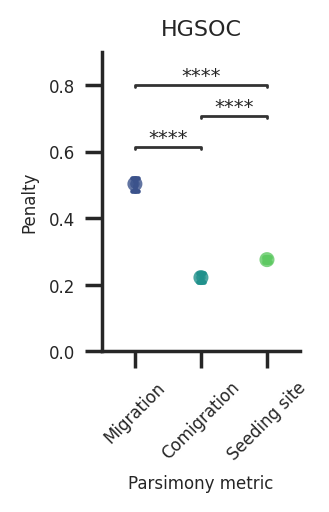

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=6.619e-14 stat=8.469e+00
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=5.140e-03 stat=2.840e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=9.676e-17 stat=9.237e+00


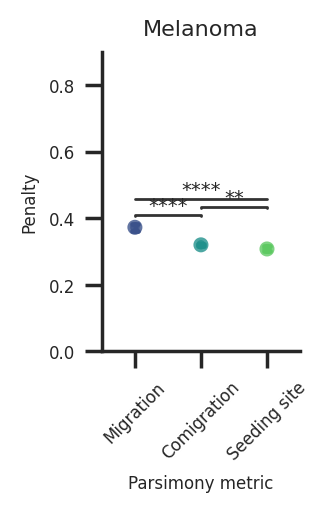

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=1.495e-60 stat=2.416e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=1.249e-08 stat=-5.997e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=3.486e-51 stat=2.293e+01


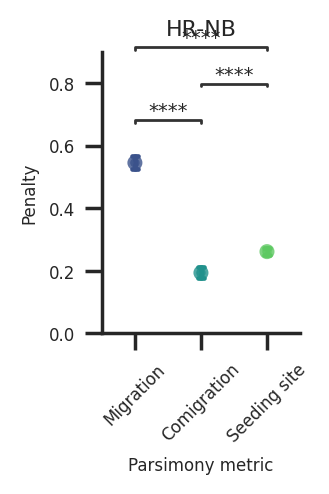

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=5.547e-45 stat=1.868e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=3.951e-47 stat=1.947e+01
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=1.598e-84 stat=3.731e+01


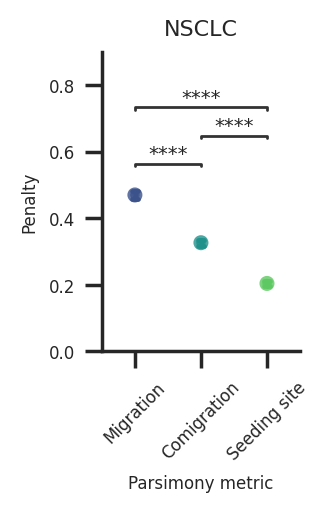

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=2.637e-82 stat=3.369e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=8.969e-14 stat=8.085e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=2.216e-92 stat=4.467e+01


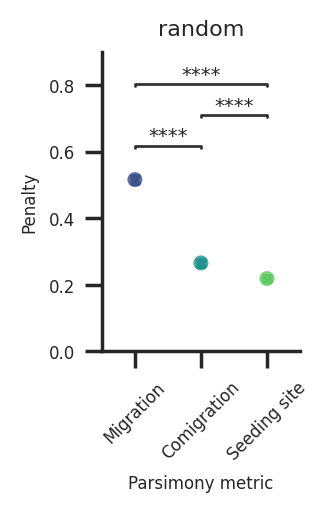

In [9]:
# Load data
thetas_split_on_same_cohort = pd.read_csv('thetas_split_on_same_cohort.csv', index_col=False).drop(columns=['Unnamed: 0']) 
thetas_split_on_random_cohort = pd.read_csv('thetas_split_on_random_cohort.csv', index_col=False).drop(columns=['Unnamed: 0']) 

colors = sns.color_palette("flare")[2:]

def point_plot(df, color, name, with_stats):
   
    sns.set(style='ticks', rc={'axes.labelsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, })

    fig = plt.figure(figsize=(2, 2.5), dpi=200)
    snsfig = sns.pointplot(data=df, x='Parsimony metric', y='Fit theta', markersize=0.5, errwidth=1.7,capsize=0.1, 
                           dodge=True, markers='.', errorbar='sd', palette='viridis')

#     snsfig = sns.violinplot(x='Parsimony metric', y='Fit theta', data=df, 
#                          linewidth=0.7, color=color, alpha=0.5, inner=None)
    
    if with_stats:
        add_stat_annotation(snsfig, data=df, x='Parsimony metric', y="Fit theta",
                            box_pairs=itertools.combinations(METRICS, 2),
                            line_offset=0.2,test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.1, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
    if with_stats:
        plt.ylim(0, 0.9) 
    else:
        plt.ylim(0, 0.7)
    plt.ylabel("Penalty")
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    saved_name = "_".join(name.split(" "))
    plt.setp(snsfig.collections, alpha=0.8)
    plt.tight_layout(pad=1.8) 
    plt.xticks(rotation=45)  
    plt.savefig(f"../output_plots/{saved_name}_theta_distribution.png", dpi=500)
    plt.title(name, fontsize=8)
    plt.show()
    plt.close()

with_stats = True
for i,dataset in enumerate(dataset_to_pickle_files):
    subset = thetas_split_on_same_cohort[thetas_split_on_same_cohort['dataset']==dataset]
    point_plot(subset, colors[i], dataset, with_stats)

point_plot(thetas_split_on_random_cohort, 'lightseagreen', 'random', with_stats)


### Make one plot per metric with datasets side by side 

    Parsimony metric  Fit theta   dataset
0          Migration      0.431  Combined
1        Comigration      0.311  Combined
2       Seeding site      0.258  Combined
3          Migration      0.547  Combined
4        Comigration      0.245  Combined
..               ...        ...       ...
295      Comigration      0.236  Combined
296     Seeding site      0.281  Combined
297        Migration      0.513  Combined
298      Comigration      0.215  Combined
299     Seeding site      0.272  Combined

[300 rows x 3 columns]
       dataset Parsimony metric  Fit theta
0        HGSOC        Migration      0.334
1        HGSOC      Comigration      0.333
2        HGSOC     Seeding site      0.333
3     Melanoma        Migration      0.333
4     Melanoma      Comigration      0.333
...        ...              ...        ...
1195     HR-NB      Comigration      0.165
1196     HR-NB     Seeding site      0.297
1197     NSCLC        Migration      0.455
1198     NSCLC      Comigration      0.361

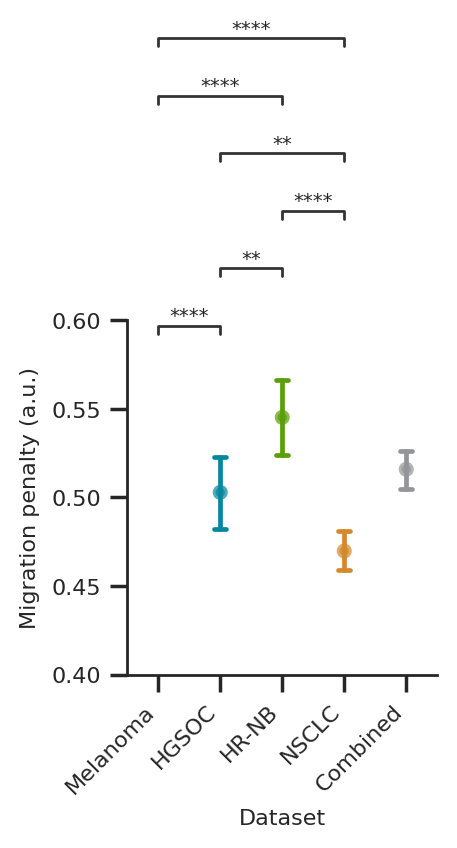

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=6.451e-23 stat=1.245e+01
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=2.346e-02 stat=2.284e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=2.605e-24 stat=-1.229e+01
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=4.121e-23 stat=-1.155e+01
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=1.944e-23 stat=1.284e+01
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=2.285e-01 stat=-1.210e+00


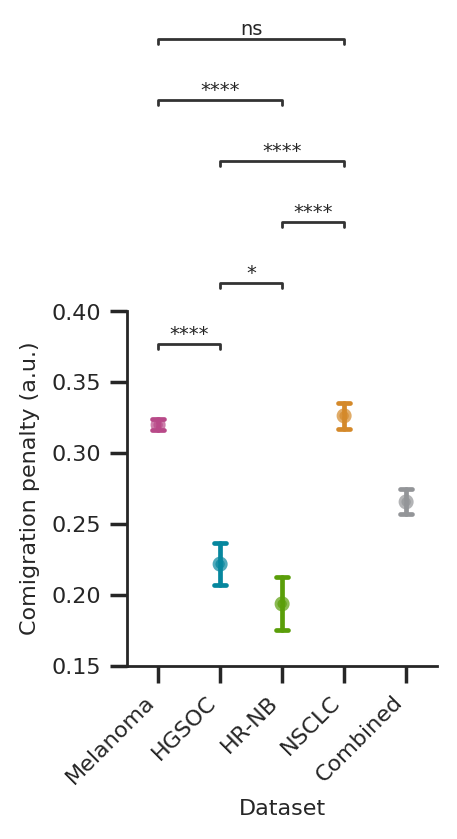

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=2.795e-09 stat=6.232e+00
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=3.651e-02 stat=2.109e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=9.630e-14 stat=8.095e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=1.868e-30 stat=1.375e+01
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=5.214e-10 stat=6.589e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.207e-45 stat=1.871e+01


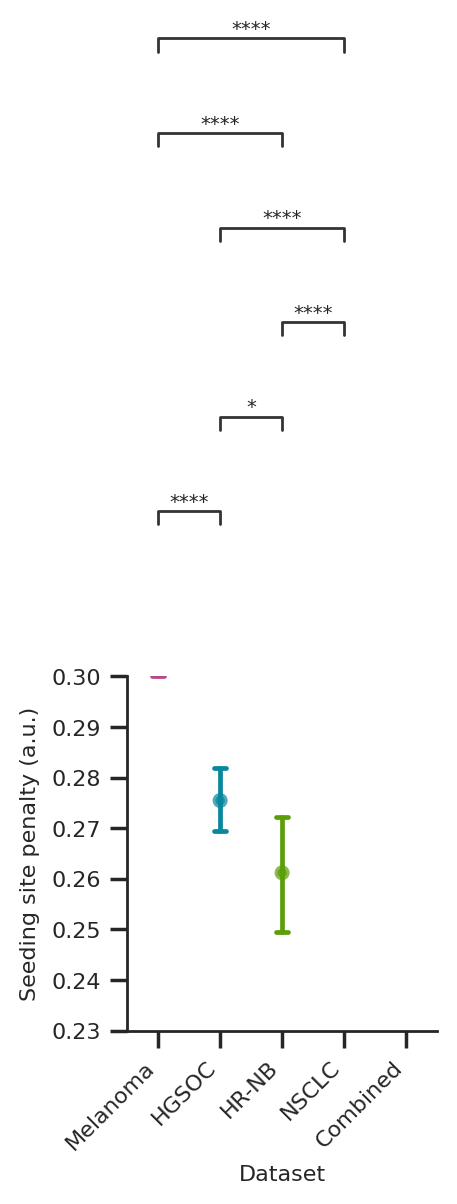

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=2.477e-22 stat=-1.172e+01
HGSOC v.s. HR-NB: Welch's t-test independent samples, P_val=7.436e-03 stat=-2.705e+00
HR-NB v.s. NSCLC: Welch's t-test independent samples, P_val=6.501e-19 stat=1.029e+01
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=1.150e-11 stat=7.364e+00
Melanoma v.s. HR-NB: Welch's t-test independent samples, P_val=6.532e-29 stat=-1.446e+01
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=2.669e-10 stat=-6.668e+00


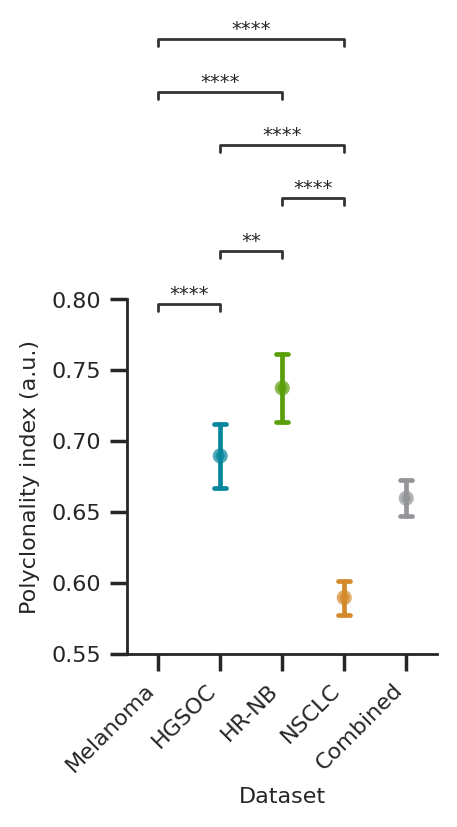

In [10]:
from matplotlib.colors import to_rgb
from statannot import add_stat_annotation
dataset_colors = ["#b84988","#06879e","#5a9e09","#d4892a", "#939598"]

dataset_order = ["Melanoma", "HGSOC", "HR-NB", "NSCLC", "Combined"]
def plot_all_metrics(df, metric, with_stats, ylim, shape=(2,2), colors=None):

    sns.set(style='ticks', rc={'axes.labelsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8,  "axes.linewidth":1.0, })
    subset = df[df['Parsimony metric']==metric]
    if with_stats:
        shape = (shape[0], shape[1]+0.3)
    fig = plt.figure(figsize=(shape[0], shape[1]), dpi=200)

    snsfig = sns.pointplot(data=subset, x='dataset', y='Fit theta', s=5, errwidth=1.7, order=dataset_order,
                           dodge=True, markers='.', errorbar='se', palette=dataset_colors, capsize=0.2)

#     snsfig = sns.violinplot(x='dataset', y='Fit theta', data=subset, palette=colors,
#                          linewidth=0.7, alpha=0.5, inner=None )

    groups = list(subset['dataset'].unique())
    
    # Plot the medians
#     medians = [np.median(subset[subset['dataset']==dataset]['Fit theta']) for dataset in set(groups)]
#     plt.setp(snsfig.collections, alpha=.3)
#     plt.scatter(x=range(len(medians)),y=medians,c="k",s=5.0, )
    
    if with_stats:
        if "Combined" in groups: groups.remove("Combined")

        line_offset = 0.17 if metric == 'Comigration' else 0.07
        add_stat_annotation(snsfig, data=subset, x='dataset', y="Fit theta",
                            box_pairs=itertools.combinations(groups, 2),order=dataset_order, line_offset=line_offset,
                            test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.05, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
        plt.ylim(ylim[0], ylim[1]) 
    else:
        plt.ylim(ylim[0], ylim[1]) 
            
    snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.xlabel("Dataset", fontsize=8)
    ylabel = f"{metric} penalty" if "index" not in metric else metric
    plt.ylabel(f"{ylabel} (a.u.)", fontsize=8)
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    saved_name = "_".join(metric.split(" "))
    plt.setp(snsfig.collections, alpha=0.7)
    #plt.tight_layout() 
    plt.savefig(f"../output_plots/{saved_name}_theta_distribution_stat.png", dpi=500,  bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()
    
thetas_split_on_random_cohort['dataset'] = "Combined"
print(thetas_split_on_random_cohort)
print(thetas_split_on_same_cohort)
combined_df = pd.concat([thetas_split_on_same_cohort, thetas_split_on_random_cohort], axis=0)
combined_df = combined_df[combined_df['dataset']!='Breast Cancer'].reset_index(drop=True)

# This is to plot the alternative metrics (Effective migration #, polyclonality index)
import math
group_size = 3
tolerance = 1e-4
rows_to_add = []
for _, group in combined_df.groupby(combined_df.index // group_size):
    assert(math.isclose(group['Fit theta'].sum(),1.0, rel_tol=tolerance, abs_tol=tolerance))
    dataset = group['dataset'].unique().item()

    mig = float(group[group['Parsimony metric']=="Migration"]["Fit theta"].item())
    comig = float(group[group['Parsimony metric']=="Comigration"]["Fit theta"].item())
    ss = float(group[group['Parsimony metric']=="Seeding site"]["Fit theta"].item())
    rows_to_add.append([dataset,  "Migration # index", 1-(mig)])
    rows_to_add.append([dataset,  "Polyclonality index", 1-(comig/(mig+comig))])
    rows_to_add.append([dataset,  "Comigration # index", 1-(comig)])
    rows_to_add.append([dataset,  "Seeding site index", 1-ss])

combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add, columns=combined_df.columns)], axis=0)

with_stats = True
plot_all_metrics(combined_df, 'Migration', with_stats, (0.4,0.6))
plot_all_metrics(combined_df, 'Comigration', with_stats,(0.15,0.4))
plot_all_metrics(combined_df, "Seeding site", with_stats, (0.23,0.3))
plot_all_metrics(combined_df, 'Polyclonality index', with_stats, (0.55,0.8))



### How concordant is the top solution when using the bootstrapped weights?

In [11]:
import torch
data = []

for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):
    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            
            pid = fn.split("/")[-1].split("_")[0]
            pkl = pickle.load(f)
            # For each patient, how would their Pareto optimal trees get reordered
            # with different bootstrapped weights?
            
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            pars_metrics = []
            for l in loss_dicts:
                pars_metrics.append((int(l[MIG_KEY]), int(l[COMIG_KEY]), int(l[SEEDING_KEY])))
            
            dataset_thetas = list(thetas_split_on_same_cohort[thetas_split_on_same_cohort['dataset']==dataset]['Fit theta'])
            for i in range(0, len(dataset_thetas), 3):
                one_samp_thetas = dataset_thetas[i:i+3]
                
                
                best_soln_loss, best_soln_idx = float("inf"), -1
                for x,pars in enumerate(pars_metrics):
                    loss = one_samp_thetas[0]*pars[0]+one_samp_thetas[1]*pars[1] + one_samp_thetas[2]*pars[2]
                    if loss < best_soln_loss:
                        best_soln_idx = x
                        best_soln_loss = loss
                
                data.append([dataset, pid, best_soln_idx])

consistency_df = pd.DataFrame(data, columns=['dataset', 'pid', 'best_soln_idx'])
consistency_df
            

HGSOC 13
Melanoma 7
HR-NB 30
NSCLC 128


,dataset,pid,best_soln_idx
0,HGSOC,7,0
1,HGSOC,7,0
2,HGSOC,7,0
3,HGSOC,7,0
4,HGSOC,7,0
...,...,...,...
17795,NSCLC,CRUK0022,0
17796,NSCLC,CRUK0022,0
17797,NSCLC,CRUK0022,0
17798,NSCLC,CRUK0022,0


In [12]:
import statistics

dataset_to_avg_concurrency = {d:[] for d in consistency_df['dataset'].unique()}
overall_avg_concurrency = []
for pid in consistency_df['pid'].unique():
    best_solutions = list(consistency_df[consistency_df['pid']==pid]['best_soln_idx'])
    mode = statistics.mode(best_solutions)
    # What percent of the boostrapped weights returns the same mode
    mode_count = best_solutions.count(mode)
    percent_mode = (mode_count / len(best_solutions)) * 100
    dataset = consistency_df[consistency_df['pid']==pid]['dataset'].unique().item()
    dataset_to_avg_concurrency[dataset].append(percent_mode)
    overall_avg_concurrency.append(percent_mode)
    
dataset_to_avg_concurrency = {k:sum(v)/len(v) for k,v in dataset_to_avg_concurrency.items()}
print(dataset_to_avg_concurrency)
print(sum(overall_avg_concurrency)/len(overall_avg_concurrency))

{'HGSOC': 95.21428571428571, 'Melanoma': 100.0, 'HR-NB': 95.5925925925926, 'NSCLC': 99.0436507936508}
98.36526946107784


In [24]:
means = thetas_split_on_same_cohort.groupby(['dataset', 'Parsimony metric'])['Fit theta'].mean().reset_index()

print(means)
print(sizes)
tot_patients = sum(list(sizes.values()))
print("tot_patients", tot_patients)
weighted_avg_mig_theta, weighted_avg_comig_theta, weighted_avg_ss_theta = 0.0,0.0,0.0
for dataset in sizes:
    avg_mig_theta = float(means[(means["dataset"]==dataset)&(means["Parsimony metric"]=='Migration')]['Fit theta'].item())
    avg_comig_theta = float(means[(means["dataset"]==dataset)&(means["Parsimony metric"]=='Comigration')]['Fit theta'].item())
    avg_ss_theta = float(means[(means["dataset"]==dataset)&(means["Parsimony metric"]=='Seeding site')]['Fit theta'].item())
    weighted_avg_mig_theta += sizes[dataset]*avg_mig_theta
    weighted_avg_comig_theta += sizes[dataset]*avg_comig_theta
    weighted_avg_ss_theta += sizes[dataset]*avg_ss_theta
    
weighted_avg_mig_theta = weighted_avg_mig_theta/tot_patients
weighted_avg_comig_theta = weighted_avg_comig_theta/tot_patients
weighted_avg_ss_theta = weighted_avg_ss_theta/tot_patients
print(weighted_avg_mig_theta, weighted_avg_comig_theta, weighted_avg_ss_theta)
    

     dataset Parsimony metric  Fit theta
0      HGSOC      Comigration      0.222
1      HGSOC        Migration      0.503
2      HGSOC     Seeding site      0.275
3      HR-NB      Comigration      0.194
4      HR-NB        Migration      0.545
5      HR-NB     Seeding site      0.261
6   Melanoma      Comigration      0.320
7   Melanoma        Migration      0.373
8   Melanoma     Seeding site      0.308
9      NSCLC      Comigration      0.326
10     NSCLC        Migration      0.470
11     NSCLC     Seeding site      0.204
{'HGSOC': 13, 'Melanoma': 7, 'HR-NB': 30, 'NSCLC': 128}
tot_patients 178
0.48110212919631706 0.296022025444233 0.2228758429375927
